In [87]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)

In [88]:
df_mvp = pd.read_excel('../collect-data/src/files/nba_data.xlsx', sheet_name='MVP')
df_mvp.head()

,Unnamed: 0,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON
0,12971,2,Karl,Malone,NaN,UTA,33,82,64,18,2997.7,2249,864,1571,55.0,0,13,0.0,521,690,75.5,193,616,809,368,233,113,48,216,4022,43,1,767,1996-97
1,12531,1,Michael,Jordan,NaN,CHI,35,82,62,20,3182.4,2357,881,1893,46.5,30,126,23.8,565,721,78.4,130,345,475,283,185,141,45,151,3725,5,0,598,1997-98
2,12093,3,Karl,Malone,NaN,UTA,35,49,36,13,1831.6,1164,393,797,49.3,0,1,0.0,378,480,78.8,107,356,463,201,162,62,28,134,2129,21,1,354,1998-99
3,11652,1,Shaquille,O'Neal,NaN,LAL,28,79,66,13,3165.2,2344,956,1665,57.4,0,1,0.0,432,824,52.4,336,742,1078,299,223,36,239,255,4688,63,0,705,1999-00
4,11212,2,Allen,Iverson,NaN,PHI,26,71,50,21,2975.9,2207,762,1813,42.0,98,306,32.0,585,719,81.4,50,223,273,325,237,178,20,147,3379,4,0,371,2000-01


# Feature Engineering

## Functions

***PCA***

In [89]:
def perform_pca(df, n_components, nominal_columns=[]):
    # Separate nominal columns from numerical columns
    numerical_columns = df.columns.difference(nominal_columns)
    nominal_data = df[nominal_columns]
    numerical_data = df[numerical_columns]
    
    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)
    
    # Apply PCA to numerical data
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)

    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    # Create a new DataFrame with the principal components
    principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    
    # Concatenate nominal data with principal components DataFrame
    if not nominal_data.empty:
        principal_df = pd.concat([nominal_data.reset_index(drop=True), principal_df], axis=1)
    
    return principal_df, cumulative_variance_ratio

***Entropy***

In [90]:
def entropy(feature):
    unique, counts = np.unique(feature, return_counts=True)
    probabilities = counts / len(feature)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

***Variance***

In [91]:
def variance(feature):
    mean = np.mean(feature)
    variance = np.mean((feature - mean) ** 2)
    return variance

## Execution

***Aggregation***

In [92]:
# df_mvp['PPG'] = df_mvp['PTS'] / df_mvp['GP'] # Points Per Game
# df_mvp['RPG'] = df_mvp['REB'] / df_mvp['GP'] # Rebounds Per Game
# df_mvp['APG'] = df_mvp['AST'] / df_mvp['GP'] # Assists Per Game
# df_mvp['SPG'] = df_mvp['STL'] / df_mvp['GP'] # Steals Per Game
# df_mvp['BPG'] = df_mvp['BLK'] / df_mvp['GP'] # Blocks Per Game
# df_mvp['PMPG'] = df_mvp['+/-'] / df_mvp['GP'] # Plus/Minus Per Game

# aggregated_to_remove = ['PTS', 'REB', 'AST', 'STL', 'BLK', '+/-']
# df_mvp = df_mvp.drop(columns=aggregated_to_remove)

***Deletion***

In [93]:
# features_to_remove = ['Unnamed: 0', 'SUFFIX', 'TEAM', 'AGE', 'MIN', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'TOV', 'PF', 'FP', 'SEASON']
# df_mvp = df_mvp.drop(columns=features_to_remove)
# df_mvp

In [94]:
# nominal_features = ['FIRST NAME', 'LAST NAME']
# pca, pca_var = perform_pca(df_mvp, 12, nominal_features)

# pca_var

In [100]:
nominal_features = ['FIRST NAME', 'LAST NAME', 'SUFFIX', 'TEAM', 'SEASON']
pca, pca_var = perform_pca(df_mvp, 10, nominal_features)

pca_var

array([0.28970741, 0.51698311, 0.65119841, 0.75431803, 0.83398661,
       0.86975238, 0.90150486, 0.92750972, 0.94765908, 0.95945998])

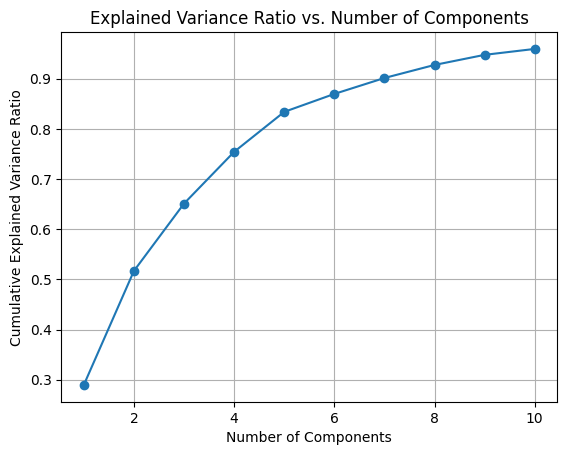

In [101]:
# Plot the cumulative explained variance ratio
plt.plot(range(1, len(pca_var) + 1), pca_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Feature Extraction